# Оглавление

* [Подключение библиотек](#Подключение-библиотек)
* [Глобальные переменные](#Глобальные-переменные)
* [Дополнительные настройки](#Дополнительные-настройки)
* [В разработке](#В-разработке)
* [Приложения](#Приложения)
* [Ссылки](#Ссылки)

# Подключение библиотек

In [1]:
import os
import numpy as np
import pandas as pd
import datetime
import calendar
import matplotlib.pyplot as plt

from pathlib import Path
from scipy.io.wavfile import write as write_wav

# Глобальные переменные

In [2]:
MAIN_DATASET_PATH = Path("E:\Arkutun-Dagi-3km(2019)06.11-09.08_AR-30")
MAIN_TARGETS_PATH = Path("E:\Arkutun-Dagi-3km_06.07-09.03_AR-34_Full.xlsx")

# Дополнительные настройки

In [3]:
# %matplotlib inline

# В разработке

## Разметочный файл

### Чтение разметочного файла

Открытие разметочного файла с расширением `.xlsx` происходит крайне медленно ([подробнее](#Чтение-оригинального-разметочного-файла)), поэтому предварительно его необходимо конвертировать в `.csv`:

In [4]:
%%time

if not MAIN_TARGETS_PATH.with_suffix('.csv').exists():
    pd.read_excel(MAIN_TARGETS_PATH).to_csv(MAIN_TARGETS_PATH.with_suffix('.csv'), index=None)

MAIN_TARGETS_PATH = MAIN_TARGETS_PATH.with_suffix('.csv')
targets = pd.read_csv(MAIN_TARGETS_PATH)

CPU times: total: 2.3 s
Wall time: 2.59 s


### Предобработка

В разметочном файле `.xlsx` можно было обнаружить пустые столбцы. Удалим их с нашего `DataFrame`:

In [5]:
targets.loc[0, :]

Source                          VYACHESLAV-TIKHONOV
DateCode                               44362.621713
Date                                     2021-06-15
Time(100%)                             14:55:16.760
T(100%)                                           7
T(90%)                                        0.601
SPLpeak(100%)(dB)                           148.045
SEL(100%)(dB)                               134.403
SEL(90%)(dB)                                133.946
SPLrms(90%)(dB)                             136.159
SEL(15-2000Hz)(100%)(dB)                    134.176
SEL(15-2000Hz)(90%)(dB)                     133.831
SPLrms(15-2000Hz)(90%)(dB)                  136.044
Kurtosis(100%)                               33.188
Kurtosis(90%)                                 0.812
SNR(90%)(dB)                                 24.963
Unnamed: 16                                        
10                                           83.161
13                                           96.117
16          

In [6]:
targets['Water part'].unique(), targets['Unnamed: 16'].unique()

(array([' '], dtype=object), array([' '], dtype=object))

In [7]:
targets.drop(labels=['Unnamed: 16', 'Water part'], axis=1, inplace=True)

In [8]:
targets.columns

Index(['Source', 'DateCode', 'Date', 'Time(100%)', 'T(100%)', 'T(90%)',
       'SPLpeak(100%)(dB)', 'SEL(100%)(dB)', 'SEL(90%)(dB)', 'SPLrms(90%)(dB)',
       'SEL(15-2000Hz)(100%)(dB)', 'SEL(15-2000Hz)(90%)(dB)',
       'SPLrms(15-2000Hz)(90%)(dB)', 'Kurtosis(100%)', 'Kurtosis(90%)',
       'SNR(90%)(dB)', '10', '13', '16', '20', '25', '32', '40', '50', '63',
       '79', '100', '126', '158', '200', '251', '316', '398', '501', '631',
       '794', '1000', '1259', '1585', '1995', 'T(100%).1', 'T(90%).1',
       'SPLpeak(100%)(dB).1', 'SEL(100%)(dB).1', 'SEL(90%)(dB).1',
       'SPLrms(90%)(dB).1', 'SEL(15-2000Hz)(100%)(dB).1',
       'SEL(15-2000Hz)(90%)(dB).1', 'SPLrms(15-2000Hz)(90%)(dB).1',
       'Kurtosis(100%).1', 'Kurtosis(90%).1', 'SNR(90%)(dB).1'],
      dtype='object')

## Набор данных

In [9]:
# Перевод АЦП (d) в микропаскали
def to_sound_pressure_decorator(f):
    grstation = 1750
    coef = (((2*7.2)/2**24)*10**12/(grstation))
    
    def wrapped(*args, **kwargs):
        info, data = f(*args, **kwargs)
        return info, (data * coef / 256) / 1000000
    
    return wrapped


def parse_num(num):
    return int(f'{num >> 4}{num & 15}')


@to_sound_pressure_decorator
def read_signal(path, step=1, stop=None):
    file = open(path, 'rb')
    header = file.read(13)
    
    data = file.read()
    
    if (stop is None) or (stop > len(data)):
        stop = len(data)
    
    date = datetime.datetime(
        year   = parse_num(header[6]) + 2000,
        month  = parse_num(header[5]),
        day    = parse_num(header[4]),
        hour   = parse_num(header[3]),
        minute = parse_num(header[2]),
        second = parse_num(header[1])
    )
    
    info = {
        'time': calendar.timegm(date.timetuple()),
        'path': path,
        'date': date,
        'sample_rate': int.from_bytes(header[10:], 'big') // 100 // step
    }
    
    res = np.array(
        [
            int.from_bytes(data[i:i + 3], 'little', signed=True)
            for i in range(0, stop, 3 * step)
        ], dtype='int32'
    )
    
    return info, res

In [10]:
files = list(MAIN_DATASET_PATH.rglob('*.*'))
files[:10]

[WindowsPath('E:/Arkutun-Dagi-3km(2019)06.11-09.08_AR-30/description.doc'),
 WindowsPath('E:/Arkutun-Dagi-3km(2019)06.11-09.08_AR-30/description.txt'),
 WindowsPath('E:/Arkutun-Dagi-3km(2019)06.11-09.08_AR-30/AFC/AUAR/NAUAR-30.GI50C-13.trans.afc'),
 WindowsPath('E:/Arkutun-Dagi-3km(2019)06.11-09.08_AR-30/AFC/AUAR/NAUAR-30.GI50C-13.trans_R.afc'),
 WindowsPath('E:/Arkutun-Dagi-3km(2019)06.11-09.08_AR-30/Data/LastFile/description.doc'),
 WindowsPath('E:/Arkutun-Dagi-3km(2019)06.11-09.08_AR-30/Data/LastFile/description.txt'),
 WindowsPath('E:/Arkutun-Dagi-3km(2019)06.11-09.08_AR-30/Data/LastFile/Data/SD_5/0061.RAW'),
 WindowsPath('E:/Arkutun-Dagi-3km(2019)06.11-09.08_AR-30/Data/LastFile/Data/SD_5/0062.RAW'),
 WindowsPath('E:/Arkutun-Dagi-3km(2019)06.11-09.08_AR-30/Data/Other/SD_0/0001.RAW'),
 WindowsPath('E:/Arkutun-Dagi-3km(2019)06.11-09.08_AR-30/Data/Other/SD_0/0002.RAW')]

In [11]:
info, signal_data = read_signal(files[11], step=1, stop=3*10**7)
info, signal_data

({'time': 1560243636,
  'path': WindowsPath('E:/Arkutun-Dagi-3km(2019)06.11-09.08_AR-30/Data/SD_0/0004.RAW'),
  'date': datetime.datetime(2019, 6, 11, 9, 0, 36),
  'sample_rate': 30240},
 array([-0.10416742, -0.1043226 , -0.10457741, ..., -0.09407465,
        -0.09406124, -0.09422217]))

In [12]:
write_wav(info['path'].with_suffix('.wav').name, info['sample_rate'], signal_data)

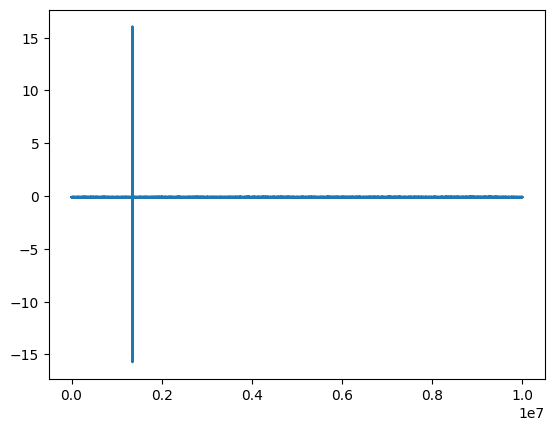

In [13]:
plt.plot(signal_data)
plt.show()

# Приложения

## Чтение оригинального разметочного файла

Более трех минут уходит на то, чтобы открыть предоставленный разметочный файл `.xlsx`, используя [`pandas.read_excel()`](https://pandas.pydata.org/docs/reference/api/pandas.read_excel.html). При этом непосредственно чтение данных происходит достаточно быстро, так как время на чтение первых 100 и 100 000 строк значительно не изменяется:

In [14]:
%%time
pd.read_excel(MAIN_TARGETS_PATH.with_suffix('.xlsx'), nrows=100)

CPU times: total: 3min 8s
Wall time: 3min 9s


,Source,DateCode,Date,Time(100%),T(100%),T(90%),SPLpeak(100%)(dB),SEL(100%)(dB),SEL(90%)(dB),SPLrms(90%)(dB),...,SPLpeak(100%)(dB).1,SEL(100%)(dB).1,SEL(90%)(dB).1,SPLrms(90%)(dB).1,SEL(15-2000Hz)(100%)(dB).1,SEL(15-2000Hz)(90%)(dB).1,SPLrms(15-2000Hz)(90%)(dB).1,Kurtosis(100%).1,Kurtosis(90%).1,SNR(90%)(dB).1
0,VYACHESLAV-TIKHONOV,44362.621713,2021-06-15,14:55:16.760,7,0.601,148.045,134.403,133.946,136.159,...,148.045,134.293,133.835,136.776,134.067,133.747,136.688,7.880,0.375,25.580
1,VYACHESLAV-TIKHONOV,44362.621713,2021-06-15,14:55:16.760,7,0.601,148.045,134.403,133.946,136.159,...,148.045,134.293,133.835,136.776,134.067,133.747,136.688,7.880,0.375,25.580
2,VYACHESLAV-TIKHONOV,44362.621956,2021-06-15,14:55:37.750,7,0.599,146.712,134.422,133.964,136.189,...,146.712,134.287,133.830,137.108,134.057,133.751,137.029,7.565,0.036,25.268
3,VYACHESLAV-TIKHONOV,44362.622199,2021-06-15,14:55:58.770,7,0.514,146.954,134.500,134.043,136.934,...,146.954,134.379,133.921,137.902,134.133,133.872,137.853,8.211,-0.273,27.507
4,VYACHESLAV-TIKHONOV,44362.622442,2021-06-15,14:56:19.770,7,0.463,146.995,134.452,133.993,137.337,...,146.995,134.356,133.899,138.229,134.142,133.862,138.193,7.965,-0.552,28.667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,VYACHESLAV-TIKHONOV,44362.645278,2021-06-15,15:29:12.240,7,0.262,156.261,140.564,140.107,145.923,...,156.261,140.535,140.078,145.965,140.480,140.010,145.897,17.451,0.189,34.372
96,VYACHESLAV-TIKHONOV,44362.645509,2021-06-15,15:29:32.190,7,0.298,157.157,142.418,141.962,147.214,...,157.157,142.400,141.942,147.208,142.370,141.873,147.139,13.346,-0.062,35.719
97,VYACHESLAV-TIKHONOV,44362.645741,2021-06-15,15:29:52.200,7,0.262,156.513,141.817,141.359,147.174,...,156.513,141.792,141.335,147.200,141.753,141.278,147.142,14.194,-0.308,34.718
98,VYACHESLAV-TIKHONOV,44362.645972,2021-06-15,15:30:12.200,7,0.276,157.571,142.425,141.968,147.565,...,157.571,142.403,141.946,147.639,142.337,141.877,147.571,14.949,-0.084,34.411


In [15]:
%%time
pd.read_excel(MAIN_TARGETS_PATH.with_suffix('.xlsx'), nrows=100_000)

CPU times: total: 3min 19s
Wall time: 3min 20s


,Source,DateCode,Date,Time(100%),T(100%),T(90%),SPLpeak(100%)(dB),SEL(100%)(dB),SEL(90%)(dB),SPLrms(90%)(dB),...,SPLpeak(100%)(dB).1,SEL(100%)(dB).1,SEL(90%)(dB).1,SPLrms(90%)(dB).1,SEL(15-2000Hz)(100%)(dB).1,SEL(15-2000Hz)(90%)(dB).1,SPLrms(15-2000Hz)(90%)(dB).1,Kurtosis(100%).1,Kurtosis(90%).1,SNR(90%)(dB).1
0,VYACHESLAV-TIKHONOV,44362.621713,2021-06-15,14:55:16.760,7,0.601,148.045,134.403,133.946,136.159,...,148.045,134.293,133.835,136.776,134.067,133.747,136.688,7.880,0.375,25.580
1,VYACHESLAV-TIKHONOV,44362.621713,2021-06-15,14:55:16.760,7,0.601,148.045,134.403,133.946,136.159,...,148.045,134.293,133.835,136.776,134.067,133.747,136.688,7.880,0.375,25.580
2,VYACHESLAV-TIKHONOV,44362.621956,2021-06-15,14:55:37.750,7,0.599,146.712,134.422,133.964,136.189,...,146.712,134.287,133.830,137.108,134.057,133.751,137.029,7.565,0.036,25.268
3,VYACHESLAV-TIKHONOV,44362.622199,2021-06-15,14:55:58.770,7,0.514,146.954,134.500,134.043,136.934,...,146.954,134.379,133.921,137.902,134.133,133.872,137.853,8.211,-0.273,27.507
4,VYACHESLAV-TIKHONOV,44362.622442,2021-06-15,14:56:19.770,7,0.463,146.995,134.452,133.993,137.337,...,146.995,134.356,133.899,138.229,134.142,133.862,138.193,7.965,-0.552,28.667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,PX-GEO-2,44382.768681,2021-07-05,18:26:54.190,7,0.224,167.077,152.849,152.391,158.889,...,167.077,152.831,152.373,159.037,152.806,152.356,159.020,16.639,-0.413,38.207
99996,PX-GEO-2,44382.768773,2021-07-05,18:27:02.660,7,0.221,166.879,153.151,152.694,159.258,...,166.879,153.133,152.676,159.259,153.113,152.657,159.241,15.105,-0.588,37.478
99997,PX-GEO-2,44382.768866,2021-07-05,18:27:10.970,7,0.217,167.467,152.227,151.768,158.408,...,167.467,152.206,151.748,158.405,152.179,151.731,158.388,18.780,-0.120,35.680
99998,PX-GEO-2,44382.768970,2021-07-05,18:27:19.370,7,0.250,168.754,152.930,152.473,158.488,...,168.754,152.910,152.453,158.668,152.889,152.434,158.649,18.030,0.066,35.136


Если конвертировать файл разметки в `.csv`, то открытие и чтение происходит меньше 5 секунд (раздел [Чтение разметочного файла](#Чтение-разметочного-файла))

# Ссылки
1. https://www.azoft.ru/blog/how-to-train-a-neural-network-to-recognize-speech/